# Sentiment Analysis - IE4483 Mini Project

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
import random

2025-11-14 05:43:18.470071: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-14 05:43:18.470375: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 05:43:18.508677: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-14 05:43:19.578189: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

In [2]:
data = pd.read_json('data/train.json')

In [3]:
data.head()

,reviews,sentiments
0,I bought this belt for my daughter in-law for ...,1
1,The size was perfect and so was the color. It...,1
2,"Fits and feels good, esp. for doing a swim rac...",1
3,These socks are absolutely the best. I take pi...,1
4,Thank you so much for the speedy delivery they...,1


In [4]:
data.shape

(7401, 2)

The training data has 7401 data points. Each data point can have a sentiment = 0 for negative reviews and sentiment = 1 for positive reviews.

In [5]:
for sentiment in [0, 1]:
    count = data[data['sentiments'] == sentiment].shape[0]
    print(f'Sentiment {sentiment}: {count} reviews')

Sentiment 0: 1082 reviews
Sentiment 1: 6319 reviews


In [8]:
indices = []
for sentiment in [0, 1]:
    cur_indices = random.sample(list(data[data['sentiments'] == sentiment].index), k=1000)
    for index in cur_indices:
        indices.append(index)

data = data.loc[indices].reset_index(drop=True)

## Text Preprocessing

In [9]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joshjms/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Stemming

Stemming gets the base form of an English word by stripping prefixes and suffixes.

### Stopwords

Stopwords are extremely common tokens (e.g. "the", "is", "and") that add little discriminative value. We can remove these stopwords safely to reduce noise and dimensionality.

In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

### Tokenization

Tokenization splits raw text into units (tokens) such as words, subwords, or sentences. This makes the text usable for model inputs.

In [11]:
def preprocess(text, stem=False):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z\s']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = []
    for token in text.split():
        if token in stop_words or len(token) <= 2:
            continue
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    return " ".join(tokens)


In [12]:
data['reviews'] = data['reviews'].apply(lambda x: preprocess(x))

In [13]:
data.head()

,reviews,sentiments
0,shoes looked wide front upon trying toes squas...,0
1,ordered dress received thought pretty put dres...,0
2,gave slippers mother christmas hold well first...,0
3,igot sailor fit baby disappointed quality gues...,0
4,item authentic kenneth cole wear shoes kenneth...,0


In [14]:
from wordcloud import WordCloud

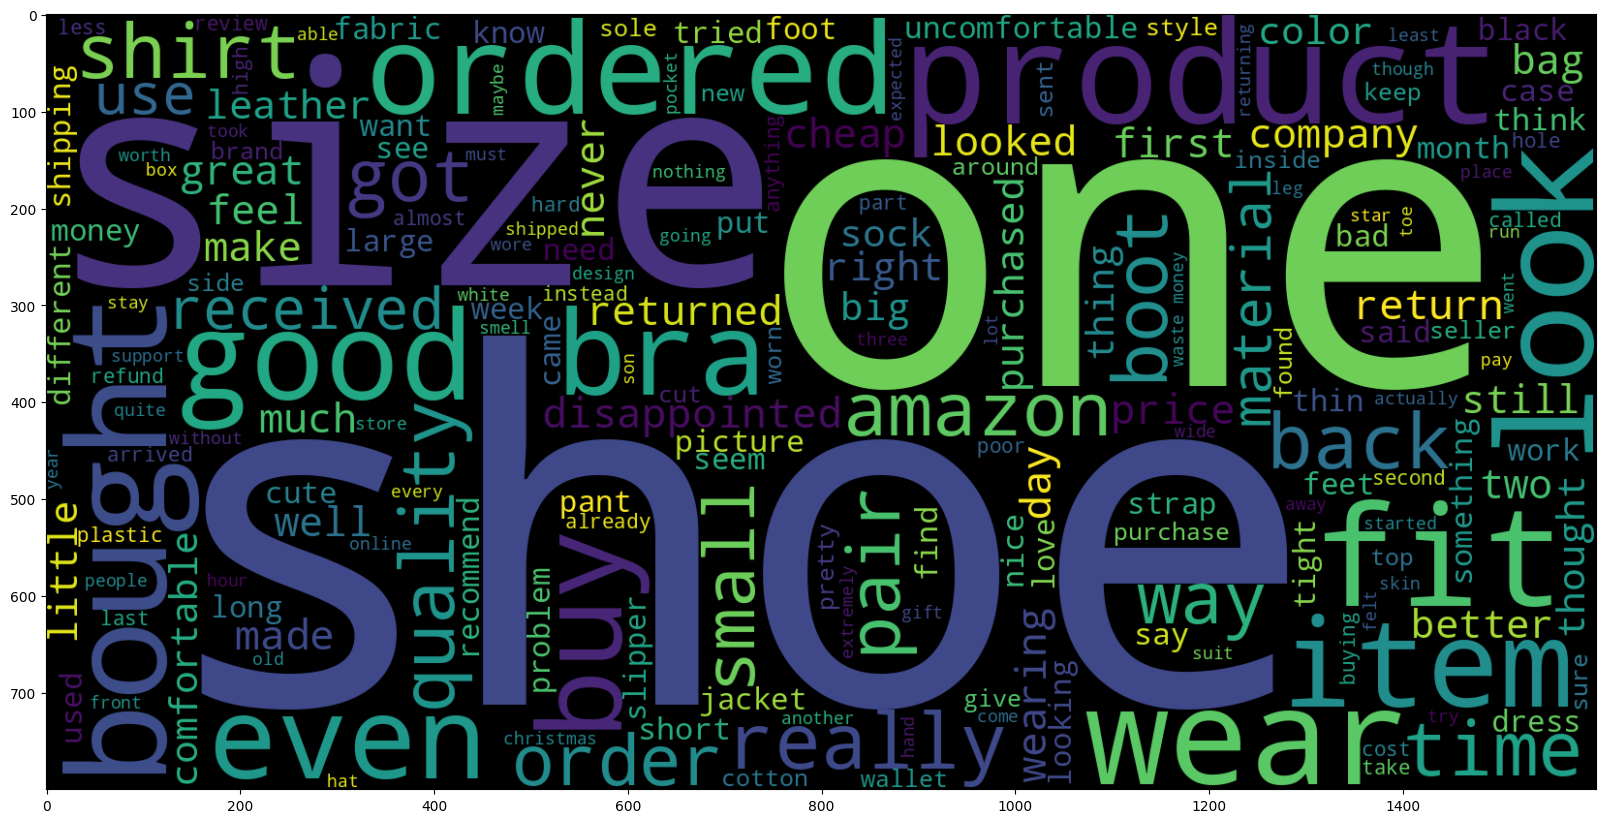

In [15]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 200 , width = 1600 , height = 800).generate(" ".join(data[data.sentiments == 0]['reviews']))
plt.imshow(wc , interpolation = 'bilinear')

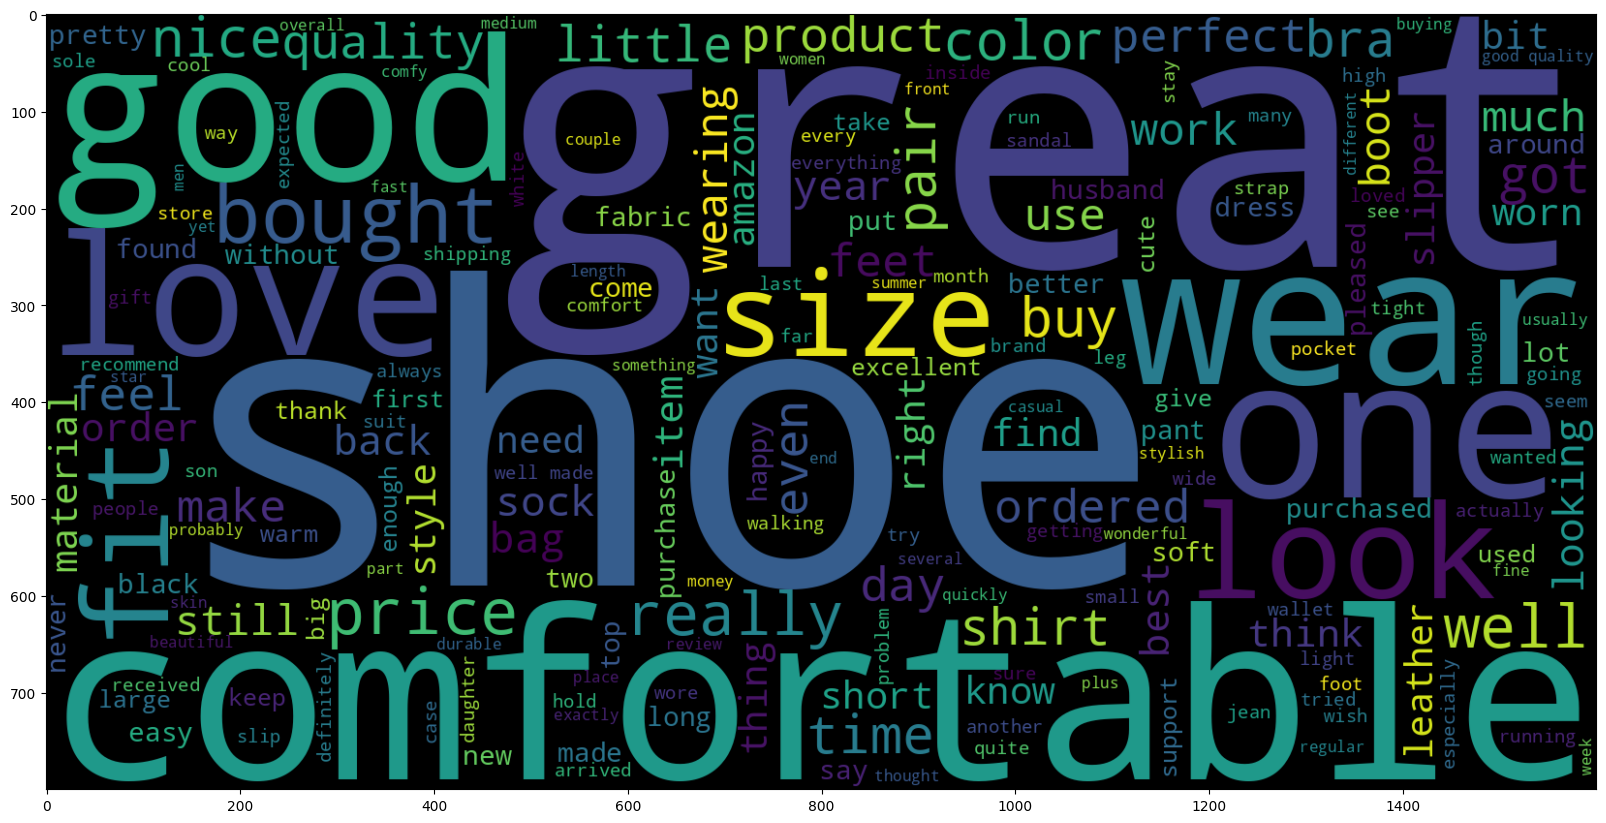

In [16]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 200 , width = 1600 , height = 800).generate(" ".join(data[data.sentiments == 1]['reviews']))
plt.imshow(wc , interpolation = 'bilinear')

## Model Training

In [17]:
TRAIN_SIZE = 0.8
train_data, test_data = train_test_split(data, train_size=TRAIN_SIZE, stratify=data['sentiments'], random_state=42)

In [18]:
MAX_TOKENS = 30000
MAX_LEN = 220

from tensorflow.keras import layers

vectorizer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode='int',
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation"
)


2025-11-14 05:43:52.144288: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [19]:
text_ds = tf.data.Dataset.from_tensor_slices(train_data['reviews']).batch(64)
vectorizer.adapt(text_ds)


2025-11-14 05:43:52.250522: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
vocab_size = len(vectorizer.get_vocabulary())
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 6504


In [21]:
review_lengths = train_data['reviews'].str.split().apply(len)
print(f"Mean tokens per review: {review_lengths.mean():.1f}")
print(f"95th percentile tokens per review: {review_lengths.quantile(0.95):.0f}")


Mean tokens per review: 28.4
95th percentile tokens per review: 69


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers

EMB_DIM = 128

model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string, name="text_input"))
model.add(vectorizer)
embedding_layer = layers.Embedding(
    input_dim=MAX_TOKENS,
    output_dim=EMB_DIM,
    mask_zero=True,
    name="embedding"
)
model.add(embedding_layer)
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(96, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid', name="sentiment"))


In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0),
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
    ],
)


In [24]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train = train_data["sentiments"].values

class_weight_vals = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=y_train
)

class_weight = {0: class_weight_vals[0], 1: class_weight_vals[1]}
print(class_weight)


{0: np.float64(1.0), 1: np.float64(1.0)}


In [25]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

train_ds = tf.data.Dataset.from_tensor_slices((
    train_data["reviews"].values,
    train_data["sentiments"].values,
)).shuffle(len(train_data)).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((
    test_data["reviews"].values,
    test_data["sentiments"].values,
)).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)


In [26]:
callbacks = [
    ModelCheckpoint(
        filepath="best_precision_model.keras",
        monitor="val_precision",
        mode="max",
        save_best_only=True,
    ),
    EarlyStopping(
        monitor="val_precision",
        mode="max",
        patience=2,
        restore_best_weights=True,
    ),
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    class_weight=class_weight,
    callbacks=callbacks,
)


Epoch 1/15


2025-11-14 05:43:56.092934: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.6169 - auc: 0.6837 - loss: 0.1836 - pr_auc: 0.6750 - precision: 0.6545 - recall: 0.4950 - val_accuracy: 0.8225 - val_auc: 0.8927 - val_loss: 0.1397 - val_pr_auc: 0.8889 - val_precision: 0.7972 - val_recall: 0.8650
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.8600 - auc: 0.9385 - loss: 0.0991 - pr_auc: 0.9360 - precision: 0.8547 - recall: 0.8675 - val_accuracy: 0.8550 - val_auc: 0.9204 - val_loss: 0.1149 - val_pr_auc: 0.9133 - val_precision: 0.8777 - val_recall: 0.8250
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.9500 - auc: 0.9852 - loss: 0.0565 - pr_auc: 0.9813 - precision: 0.9444 - recall: 0.9563 - val_accuracy: 0.8250 - val_auc: 0.9123 - val_loss: 0.1275 - val_pr_auc: 0.9009 - val_precision: 0.7955 - val_recall: 0.8750
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.9775 - auc: 0.9970 - loss: 0.0294 - pr_auc: 0.9973 - precision: 0.9775 - recall: 0.9775 - val

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

checkpoint_path = "best_precision_model.keras"
evaluation_model = model
if os.path.exists(checkpoint_path):
    evaluation_model = tf.keras.models.load_model(checkpoint_path)
    print(f"Loaded best checkpoint from {checkpoint_path}")
else:
    print("Checkpoint not found, using current model weights.")

y_true = test_data["sentiments"].values
y_pred_prob = evaluation_model.predict(test_ds).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print(classification_report(y_true, y_pred, digits=4))
print(confusion_matrix(y_true, y_pred))


Loaded best checkpoint from best_precision_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

           0     0.8349    0.8850    0.8592       200
           1     0.8777    0.8250    0.8505       200

    accuracy                         0.8550       400
   macro avg     0.8563    0.8550    0.8549       400
weighted avg     0.8563    0.8550    0.8549       400

[[177  23]
 [ 35 165]]
